Convert a IMOD .idf output result to the Ugrid NetCDF format that can be used by D-Eco Impact

In [1]:
#load required libraries and prepare logging
import os
import xugrid as xu
import xarray as xr
import geopandas as gpd
import numpy as np
import rioxarray
import rasterio
import xarray
import logging
import imod

logger = logging.getLogger(__name__)

import sys  
sys.path.insert(1, '../library')
from DEcoImpact_conv_func import DEIModel

In [2]:
#configuration
os.chdir(r"p:\11210262-001-stakeholders-tools\Virtual_Climate_Lab\Maaike\decoimpact")

## PARAMETERS
modelname = 'referentie_2021_reduced'

## INVOER
heads = imod.idf.open(r"p:\11210262-001-stakeholders-tools\Virtual_Climate_Lab\Maaike\idfs\reference\head_2016*_l*.idf")
area = rioxarray.open_rasterio(r'p:\11210262-001-stakeholders-tools\Virtual_Climate_Lab\01_data\dataset\originele_bodem.tif')

#Where to write the D-Eco impact input file
ds_out = "DEI_IMOD_output_"+ modelname + ".nc"
crs_code = "epsg:28992"


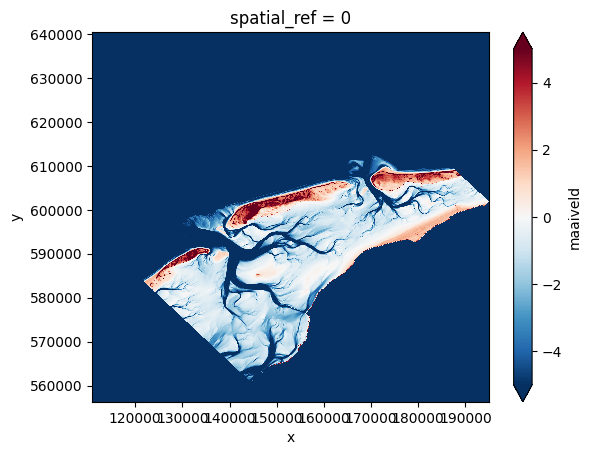

In [3]:
#maaiveld voorbereiding
maaiveld_da = area.isel(band = 0)
maaiveld_da = maaiveld_da.drop("band")
maaiveld_da = maaiveld_da.rename("maaiveld")
maaiveld_ds = maaiveld_da.to_dataset()
maaiveld_ds_fv = maaiveld_ds.where(maaiveld_ds['maaiveld'] != -9999.)  
maaiveld_ds_fv["maaiveld"].plot.imshow()

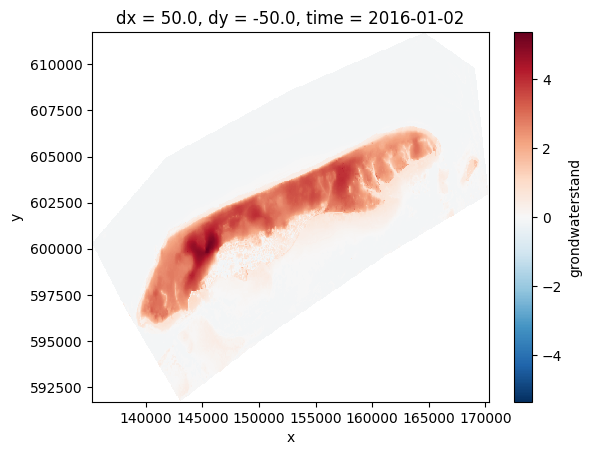

In [4]:
## Freatische grondwaterstand berekenen
upper_active_layer = imod.select.upper_active_layer(heads.isel(time=0), is_ibound=False)
#print(upper_active_layer.isnull().all())

heads_freatic = heads.where(heads.layer == upper_active_layer)

#select layer value without nan values
heads_freatic = heads_freatic.min("layer")

dataset = xr.Dataset()
dataset['grondwaterstand'] = heads_freatic

#present the data
dataset['grondwaterstand'].isel(time=0).plot.imshow()



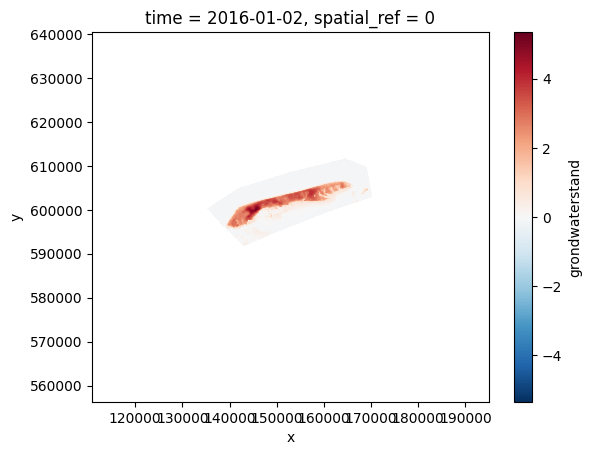

In [5]:
#regird the data based on the bathymetry
multilin_regridder = imod.prepare.Regridder(method = "multilinear", ) # prepare
da_regridded = multilin_regridder.regrid(dataset['grondwaterstand'], maaiveld_ds_fv["maaiveld"])
da_regridded = da_regridded.rename("grondwaterstand")
da_regridded.isel(time =0).plot.imshow()




<xarray.Dataset> Size: 7GB
Dimensions:                       (time: 25, y: 4206, x: 4206)
Coordinates:
  * time                          (time) datetime64[ns] 200B 2016-01-02 ... 2...
  * y                             (y) float64 34kB 6.404e+05 ... 5.563e+05
  * x                             (x) float64 34kB 1.108e+05 ... 1.95e+05
    spatial_ref                   int32 4B 0
Data variables:
    grondwaterstand               (time, y, x) float64 4GB dask.array<chunksize=(1, 4206, 4206), meta=np.ndarray>
    maaiveld                      (y, x) float64 142MB -9.999e+03 ... -9.999e+03
    grondwaterstand_tov_maaiveld  (time, y, x) float64 4GB dask.array<chunksize=(1, 4206, 4206), meta=np.ndarray>


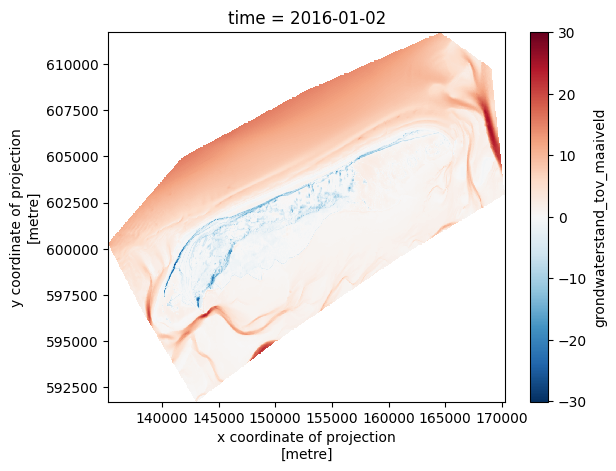

In [6]:
#make dataset grondwaterstand and maaiveld
dataset_combined = xr.merge([da_regridded, maaiveld_ds_fv], compat="identical")
dataset_combined["grondwaterstand_tov_maaiveld"] = dataset_combined["grondwaterstand"] - dataset_combined["maaiveld"]

print(dataset_combined)

#clip the dataset by a bounding box of the model
min_x = dataset.x.min().item() ; max_x = dataset.x.max().item()
min_y = dataset.y.min().item() ; max_y = dataset.y.max().item()

dataset_combined_mdim = dataset_combined.rio.clip_box(min_x,min_y,max_x,max_y)
dataset_combined_mdim = dataset_combined_mdim.drop("spatial_ref")

# show result
dataset_combined_mdim["grondwaterstand_tov_maaiveld"].isel(time=0).plot.imshow()

In [7]:
## Tussentijds opslaan
temp_output_name = f'example_output_data/Grondwaterstand_tov_mv_{modelname}.nc'
dataset_combined_mdim.to_netcdf(temp_output_name)

In [9]:
#initialize
DEI = DEIModel()
cwd = os.getcwd()
DEI.set_root(root = cwd)

#read Netcdf
region_dict = {"imod": temp_output_name}
DEI.setup_ugrid(region = region_dict, crs = crs_code)
DEI._mesh2d["time"] = DEI._mesh2d["time"].assign_attrs({"_FillValue": False})
print(DEI._mesh2d)



#export result
DEI.write_mesh(fn_temp = "example_output_data/temporary_file.nc", fn_ecoimpact = "example_output_data/"+ds_out)

print("Done.")

<xarray.Dataset> Size: 884MB
Dimensions:                       (mesh2d_nNodes: 1755504, time: 25,
                                   mesh2d_nFaces: 1752751,
                                   mesh2d_nEdges: 3508254)
Coordinates:
    mesh2d_node_x                 (mesh2d_nNodes) float64 14MB 1.353e+05 ... ...
    mesh2d_node_y                 (mesh2d_nNodes) float64 14MB 6.117e+05 ... ...
  * time                          (time) datetime64[ns] 200B 2016-01-02 ... 2...
    mesh2d_edge_x                 (mesh2d_nEdges) float64 28MB 1.353e+05 ... ...
    mesh2d_edge_y                 (mesh2d_nEdges) float64 28MB 6.117e+05 ... ...
    mesh2d_face_x                 (mesh2d_nFaces) float64 14MB 1.353e+05 ... ...
    mesh2d_face_y                 (mesh2d_nFaces) float64 14MB 6.117e+05 ... ...
  * mesh2d_nNodes                 (mesh2d_nNodes) int64 14MB 0 1 ... 1755503
  * mesh2d_nEdges                 (mesh2d_nEdges) int64 28MB 0 1 ... 3508253
  * mesh2d_nFaces                 (mesh2d_nFaces) 

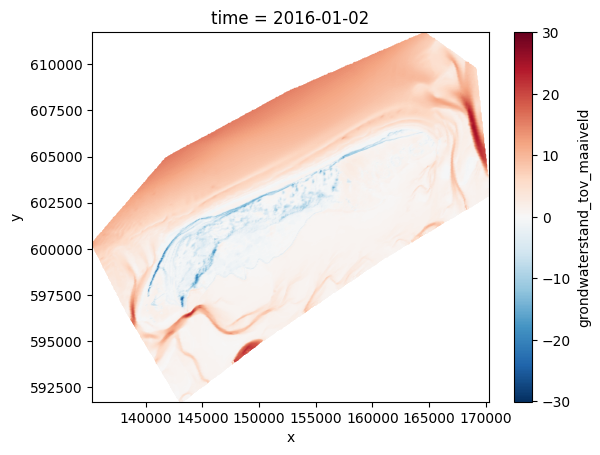

In [11]:
#visualize results
with xu.open_mfdataset("example_output_data/"+ds_out) as result:
    result["grondwaterstand_tov_maaiveld"].isel(time= 0).ugrid.plot()